In [53]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [54]:
from nn_resampler import nn_resampler
from phase_est_smc import phase_est_smc

In [55]:
num_particles = 1000 # number of SMC particles (num of w points)
num_samples = 10000 # number of samples to draw from the particle distribution (to be binned)
num_bins = 100 # number of bins
n_iters = 100 # number of different omega*
t0 = 10 # starting time
max_iters = 200 # maximum number of iterations before breaking
if_print = True

In [56]:
net = nn_resampler(num_bins,num_bins)
net.load_state_dict(torch.load("model/nn_resampler.model"))
net.eval();

## NN Resampler

In [57]:
omega_star_list = []
nn_pred_list = []
nn_data = []

for i in range(n_iters): 
    
    omega_star = np.random.uniform(low=-1, high =1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    resample_counts = 0
    
    while True:
        
        particle_pos, particle_wgts = smc.particles(threshold=num_particles/5, num_measurements=1)
        bins, edges = smc.get_bins(num_bins, num_samples)
        
        if smc.break_flag:
            break
            
        nn_pred = net(torch.tensor(bins).float().unsqueeze(0)) ## convert to float tensor, then make dim [1, num_bins]
        smc.nn_bins_to_particles(nn_pred.detach().numpy(), edges)
        
        resample_counts += 1

        
#         if len(running_est) > 5:
#             last_n = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shake of last_n with every element being last_n[0]
#             # if all elements of last_n are equal then they should all equal the first element
#             if np.allclose(last_n, np.full_like(last_n, last_n[0])):
#                 break
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate
    
    nn_data.append(smc.data)
    nn_pred_list.append(smc.curr_omega_est)
    
    if np.abs(smc.curr_omega_est) - np.abs(omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))
        break

True omega: -1.576951, prediction by NN: 1.599038, num of resample calls: 44
True omega: 0.817889, prediction by NN: 0.933214, num of resample calls: 44
True omega: 0.892999, prediction by NN: 0.784462, num of resample calls: 45
True omega: -2.799165, prediction by NN: -2.142966, num of resample calls: 45
True omega: -0.611274, prediction by NN: 0.281791, num of resample calls: 44
True omega: -1.067909, prediction by NN: 0.079058, num of resample calls: 45
True omega: -0.308675, prediction by NN: -0.425358, num of resample calls: 44
True omega: -2.731946, prediction by NN: -0.588592, num of resample calls: 44
True omega: -2.775007, prediction by NN: -1.616146, num of resample calls: 44
True omega: 1.638054, prediction by NN: 1.513080, num of resample calls: 44
True omega: 2.745507, prediction by NN: -2.749614, num of resample calls: 43
True omega: 2.050485, prediction by NN: -1.606688, num of resample calls: 45
True omega: 1.561855, prediction by NN: 3.002040, num of resample calls: 44

i= 0


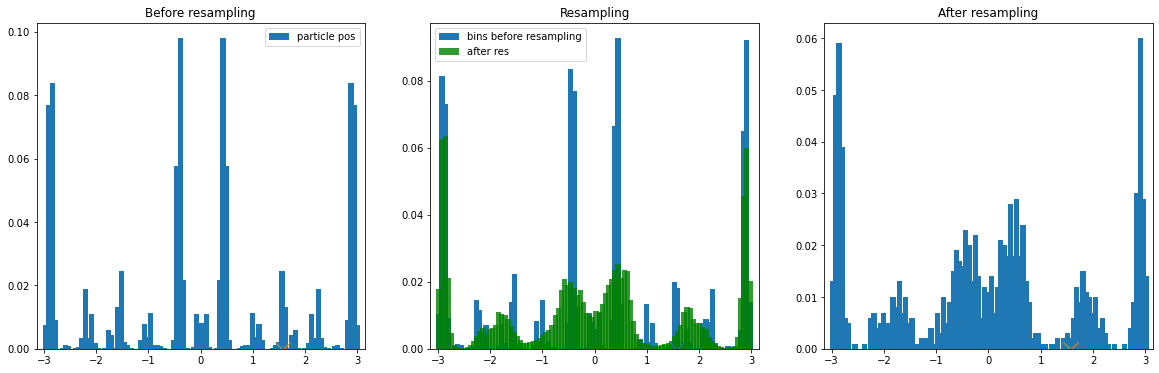

i= 1


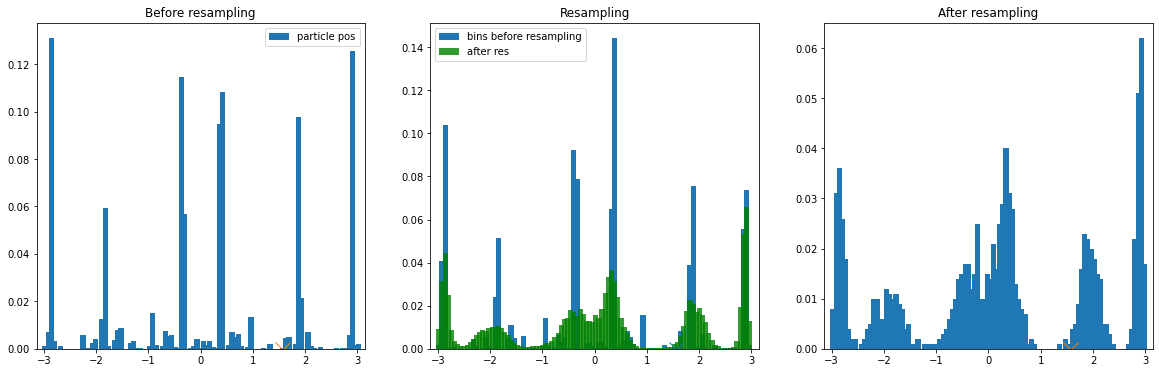

i= 2


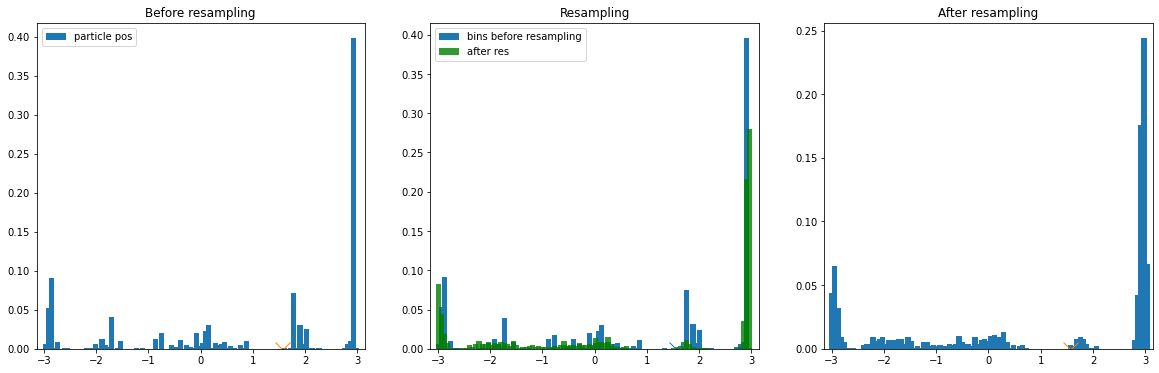

i= 3


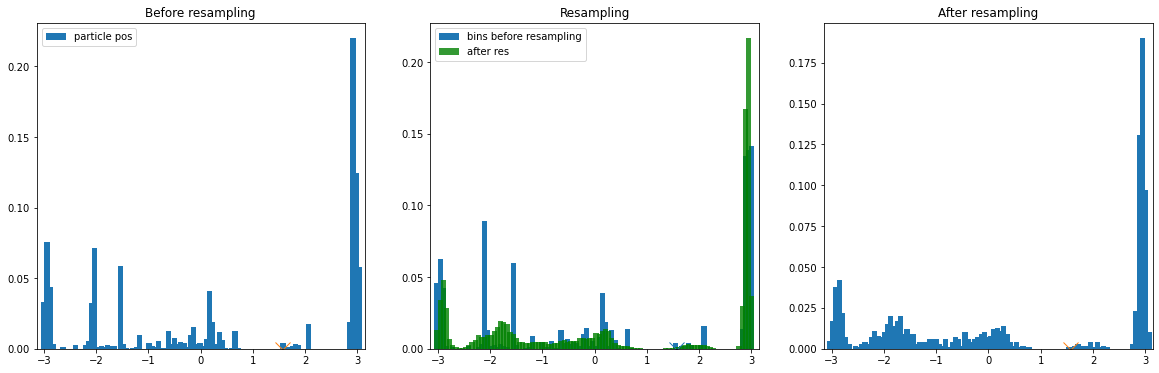

i= 4


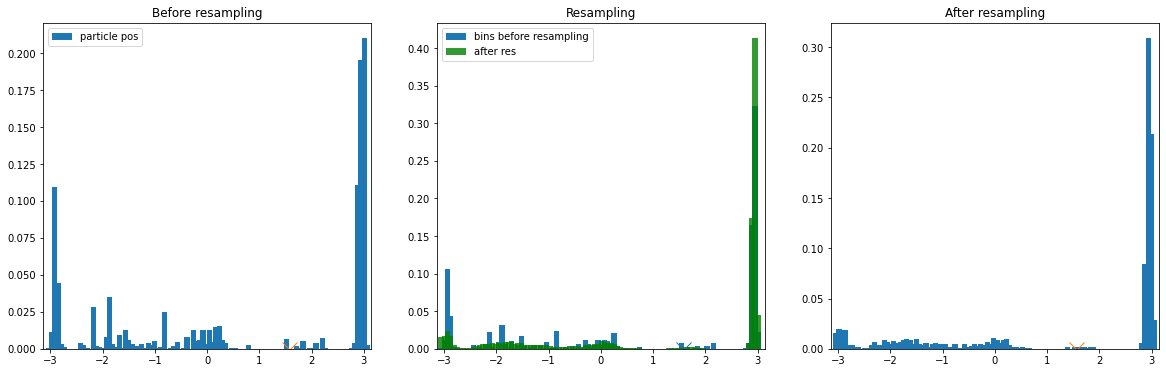

i= 5


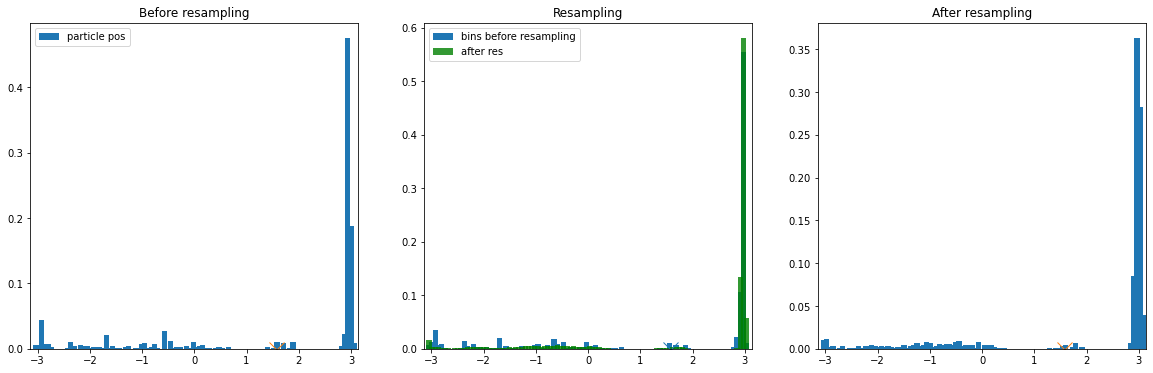

i= 6


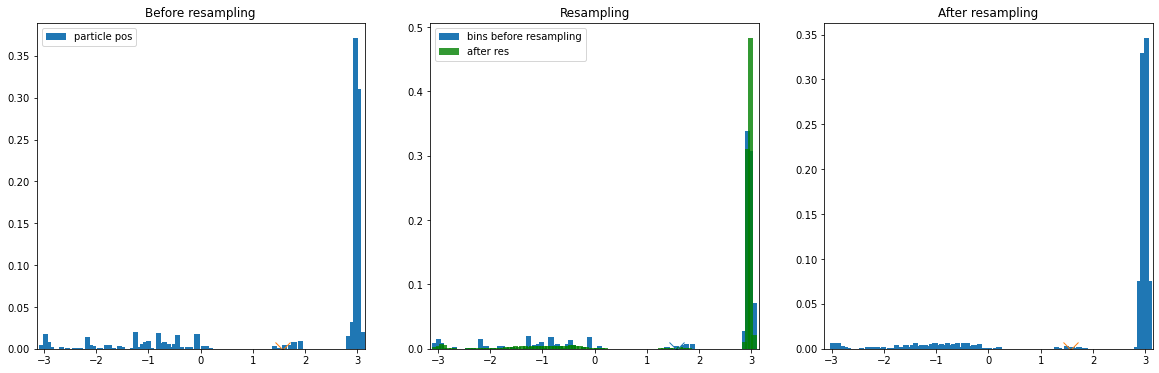

i= 7


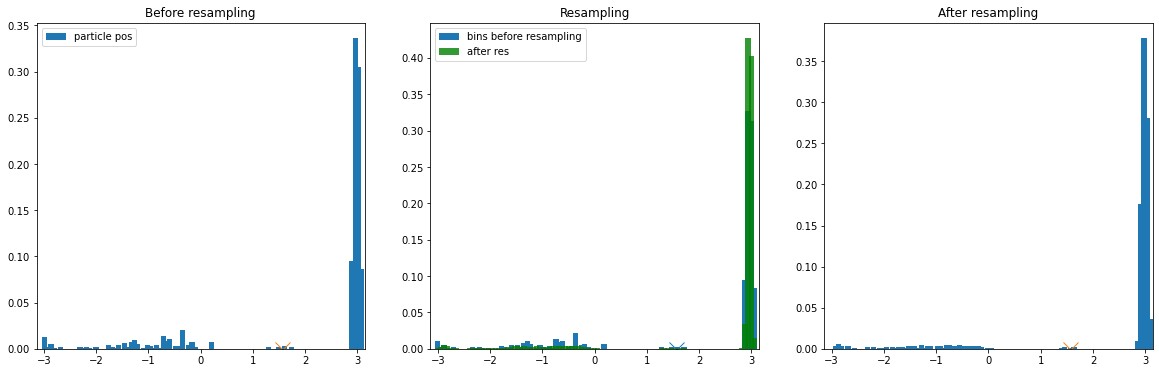

i= 8


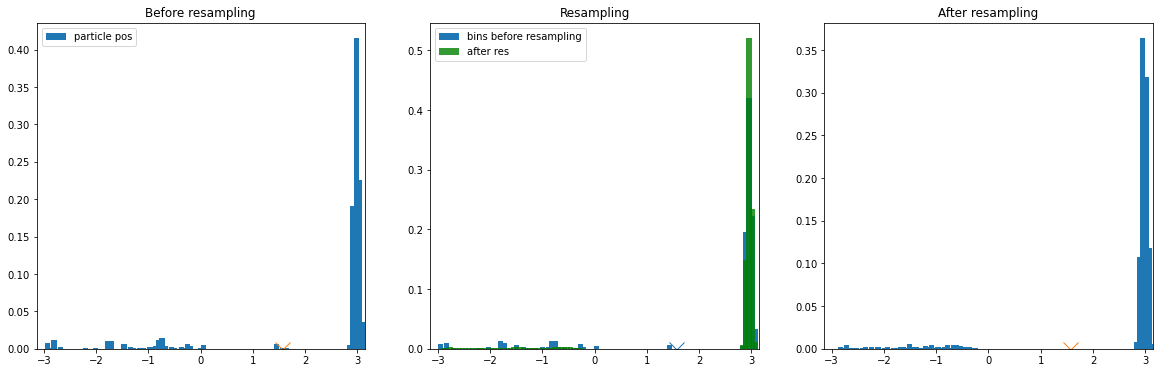

i= 9


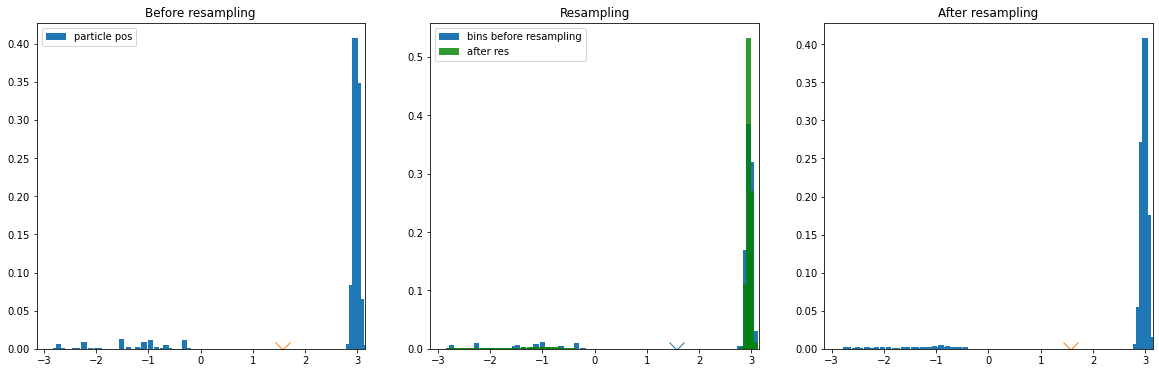

i= 10


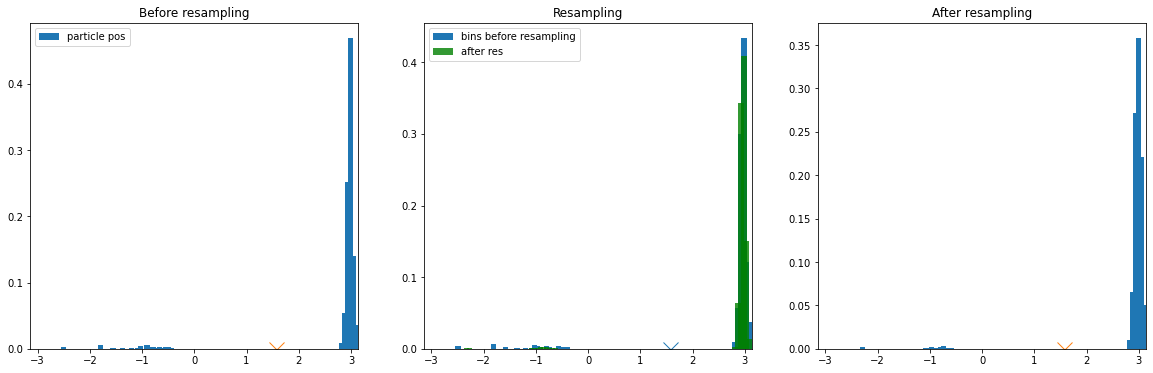

i= 11


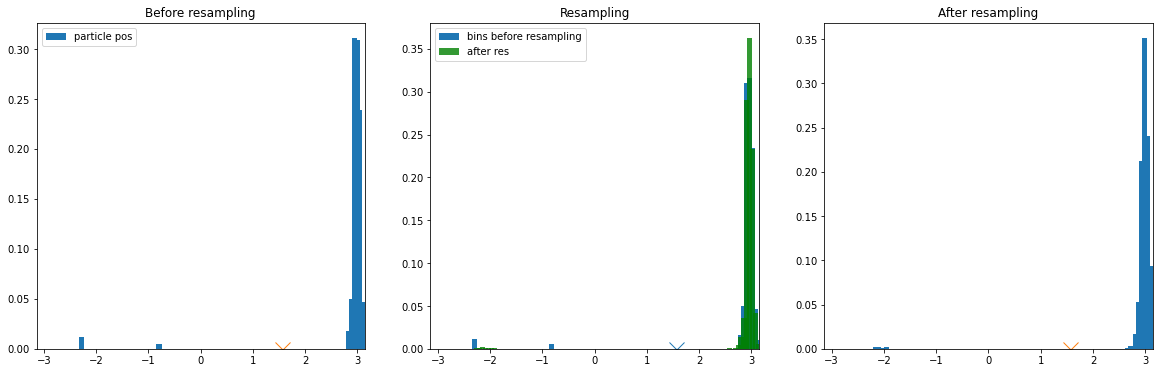

i= 12


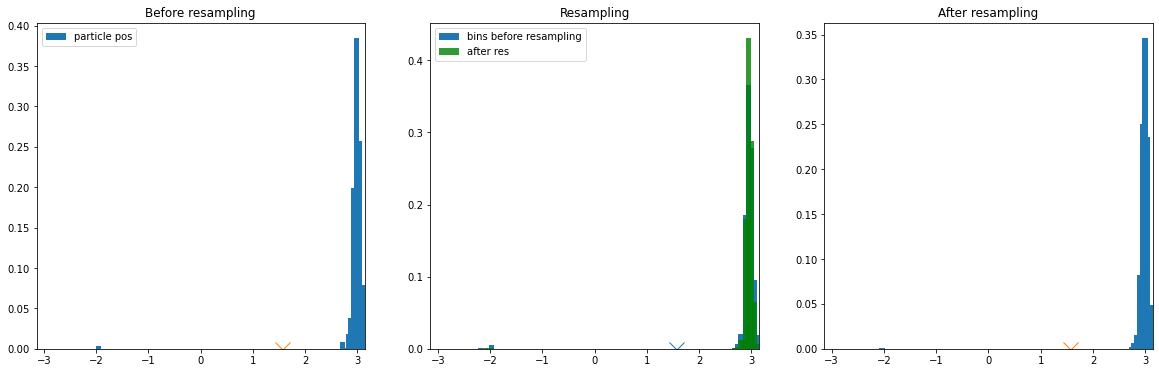

i= 13


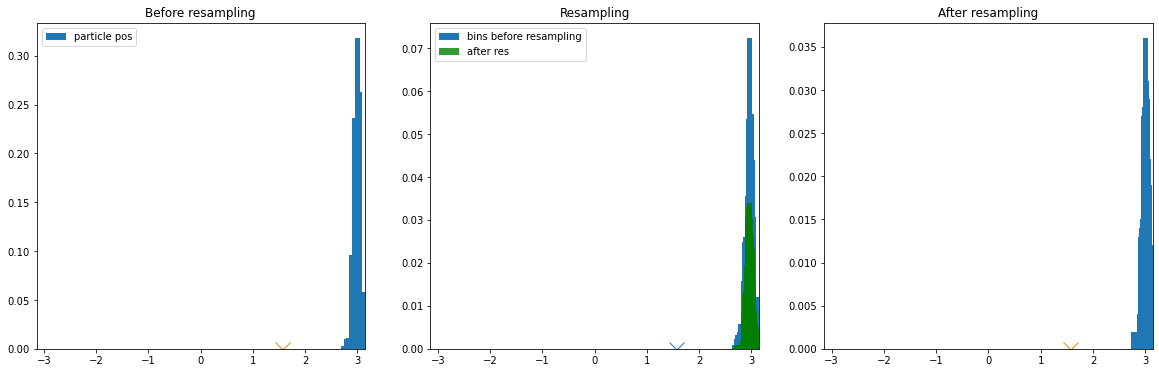

i= 14


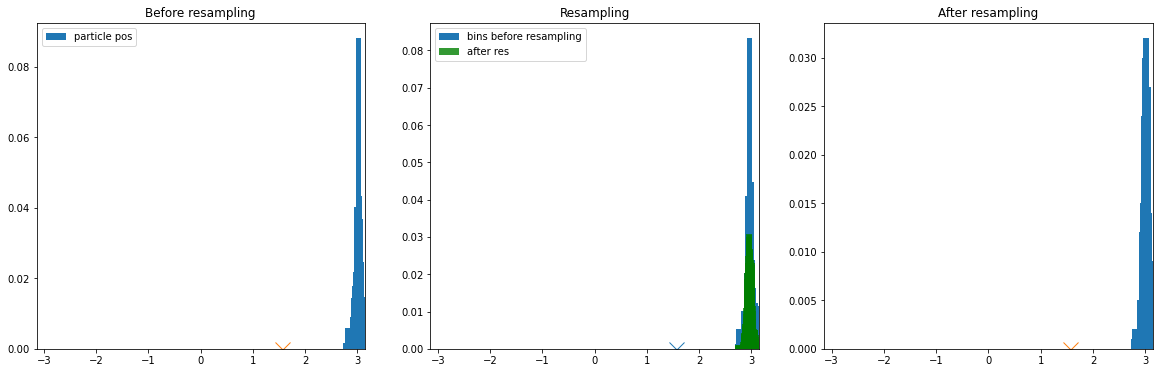

i= 15


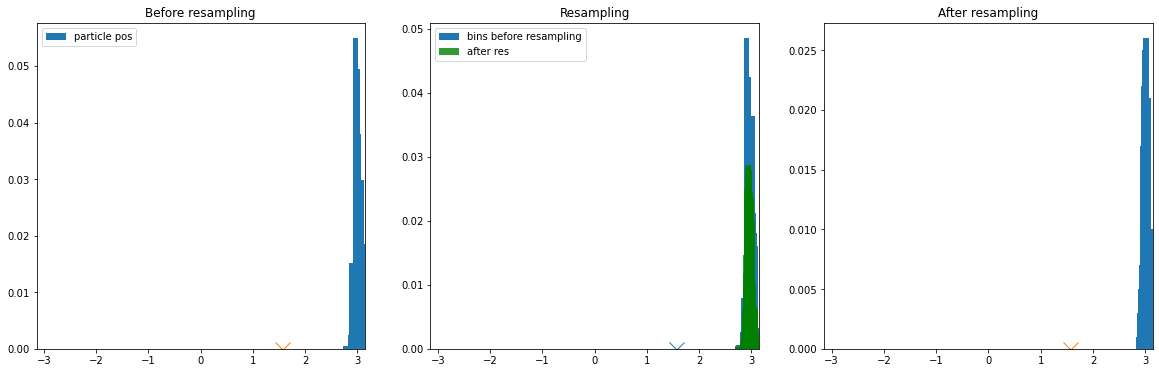

i= 16


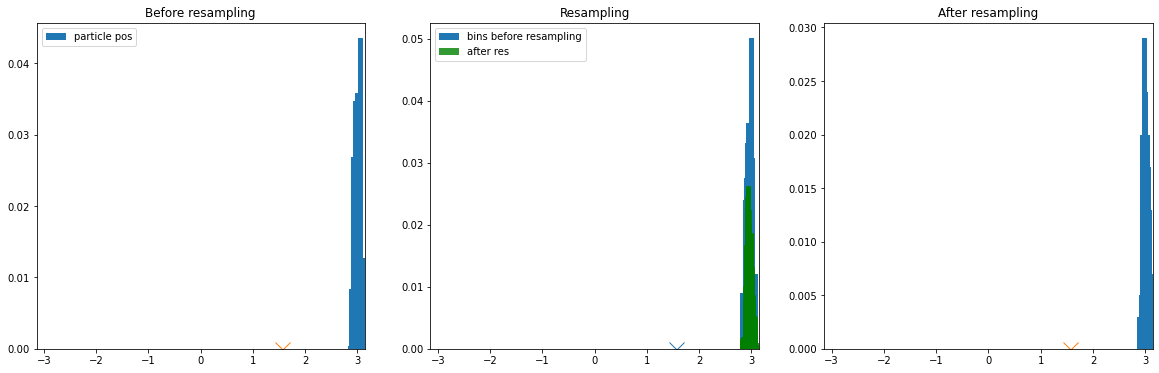

i= 17


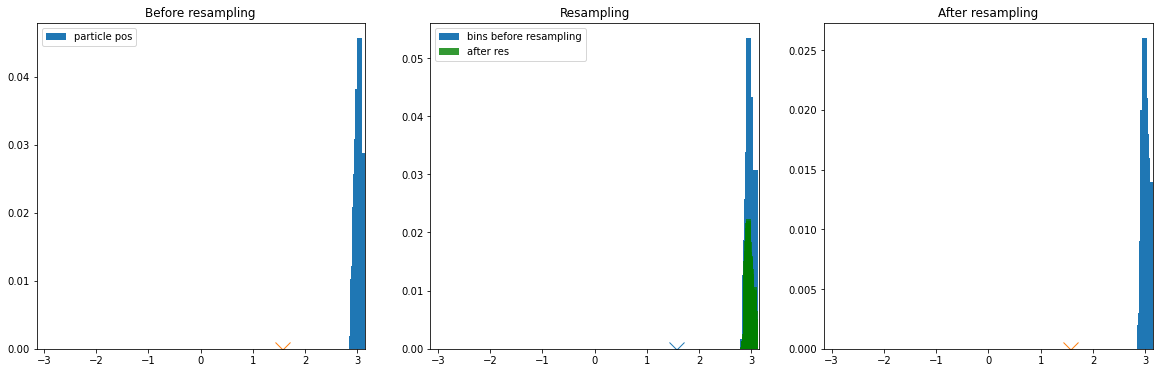

i= 18


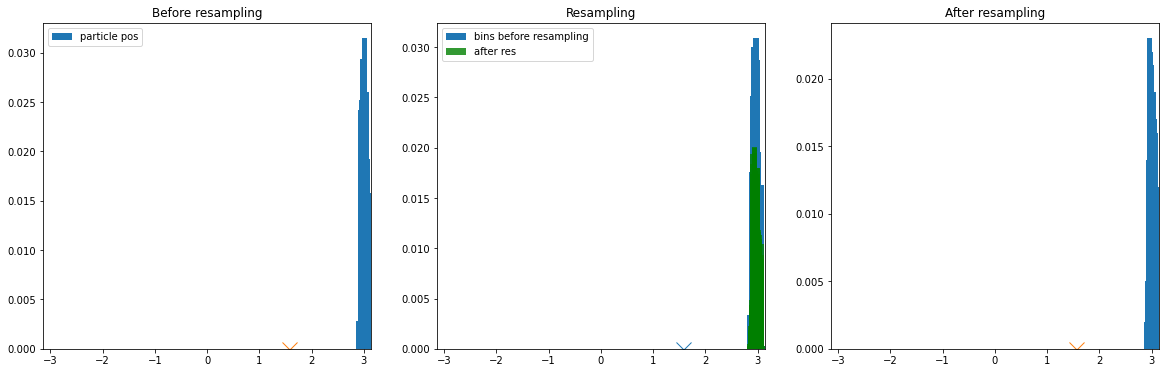

i= 19


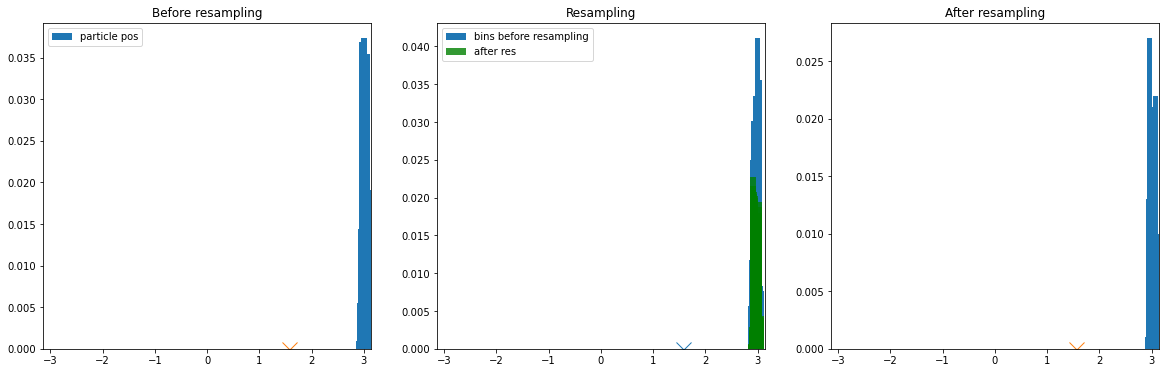

i= 20


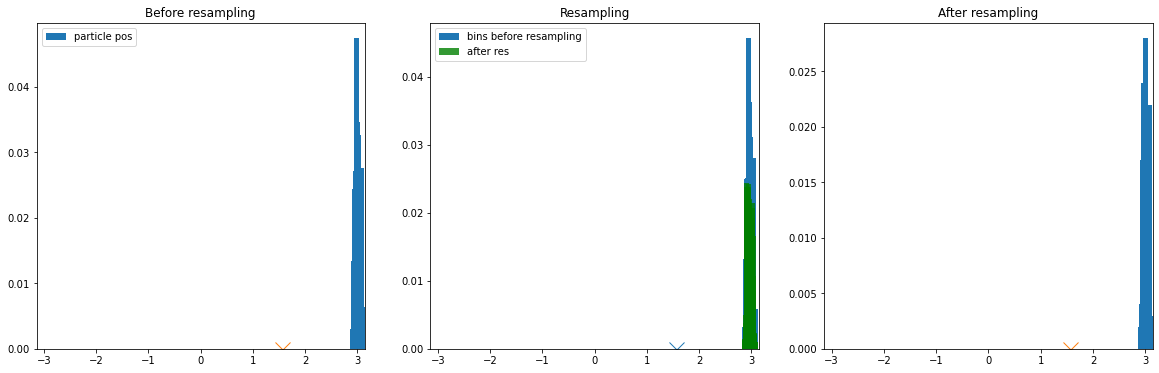

i= 21


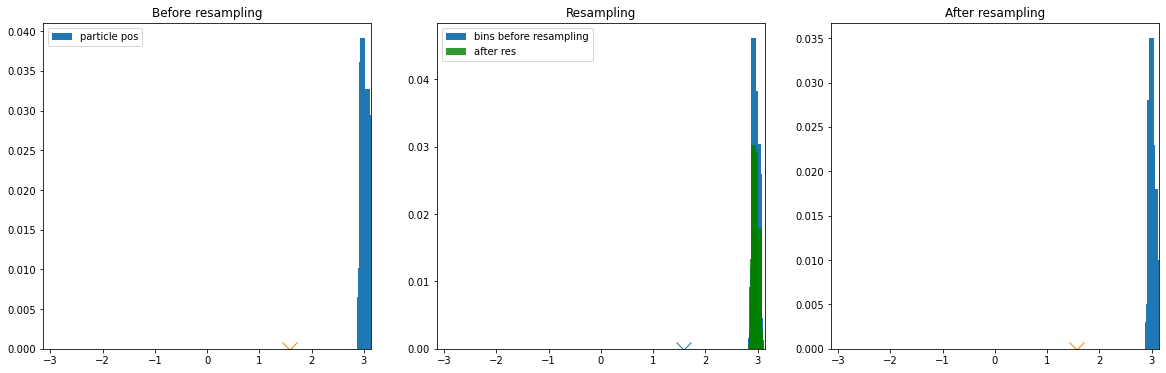

i= 22


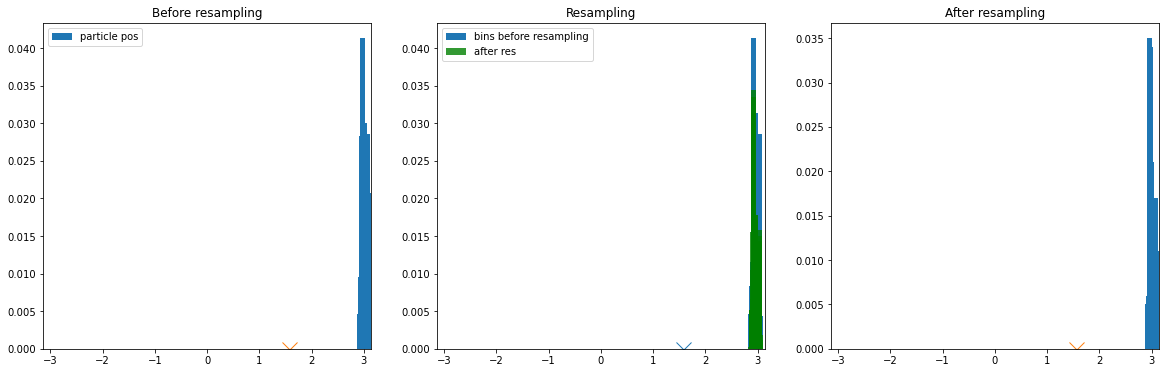

i= 23


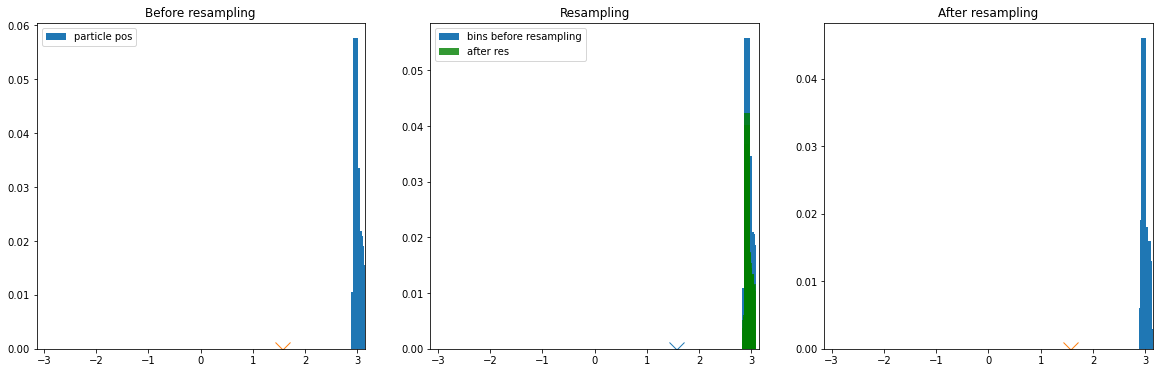

i= 24


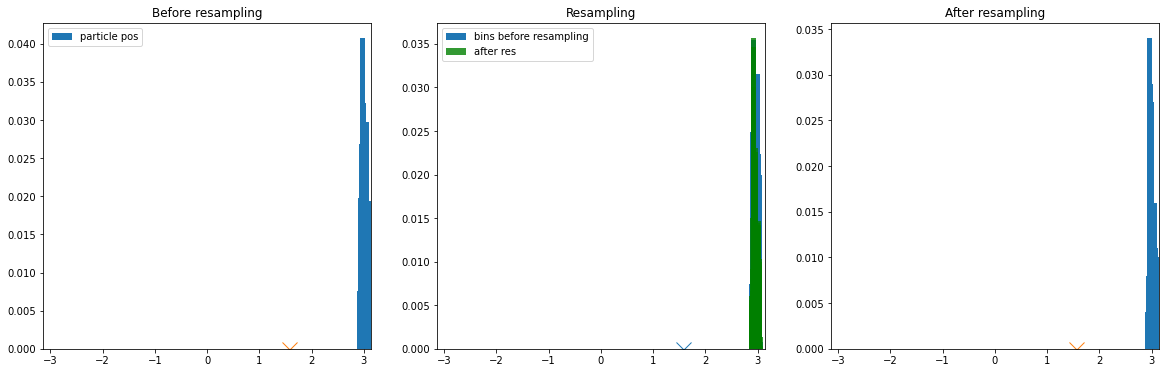

i= 25


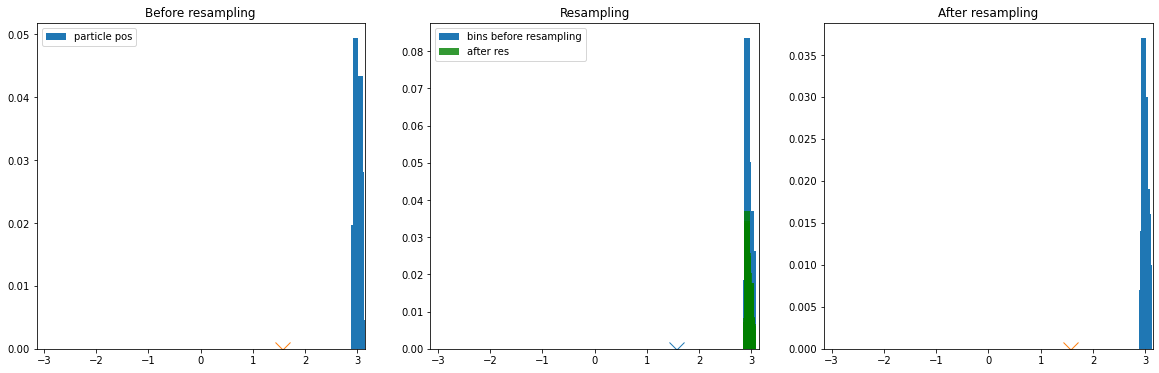

i= 26


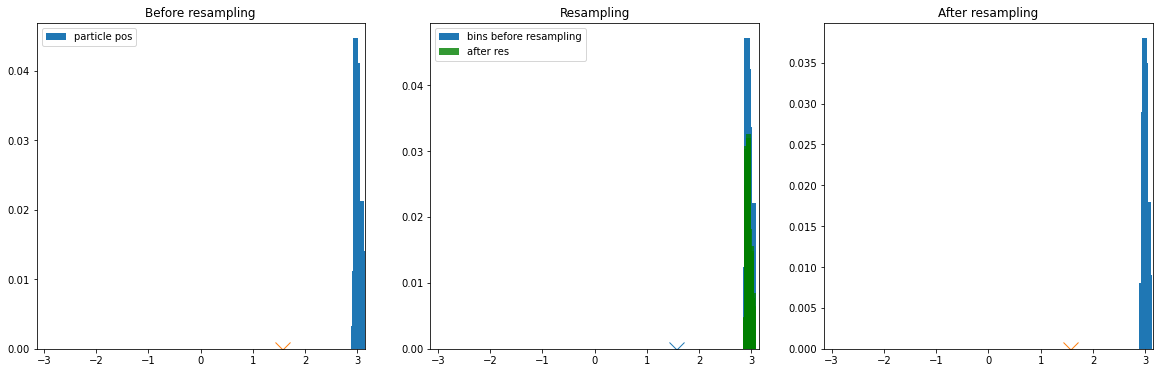

i= 27


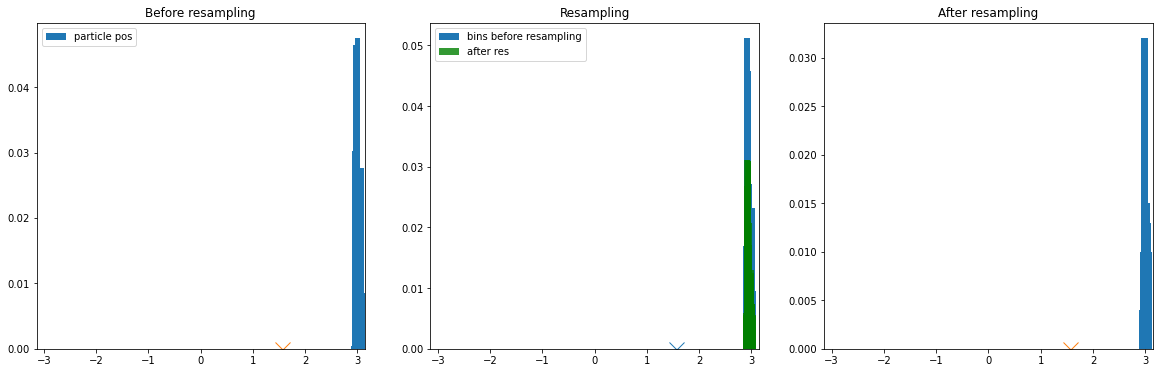

i= 28


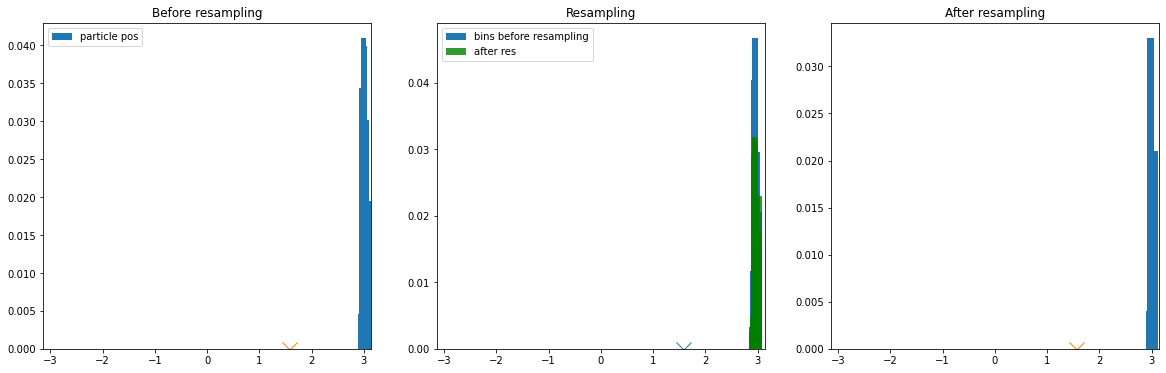

i= 29


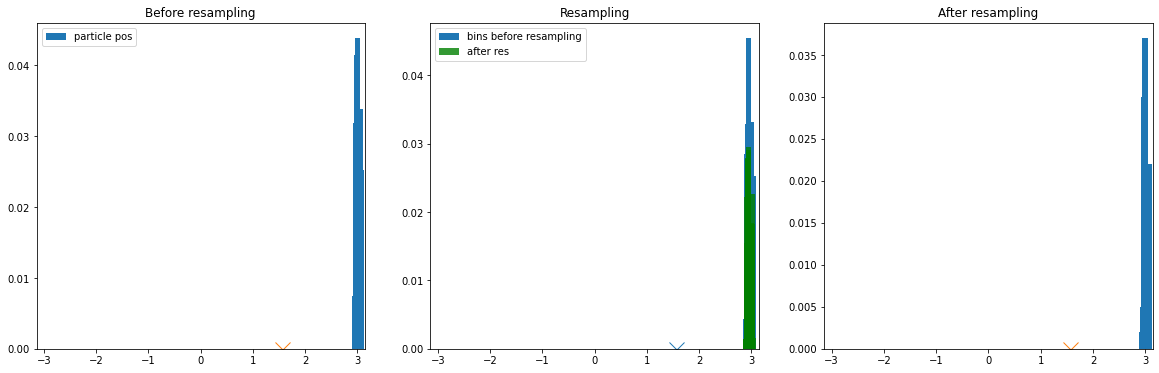

i= 30


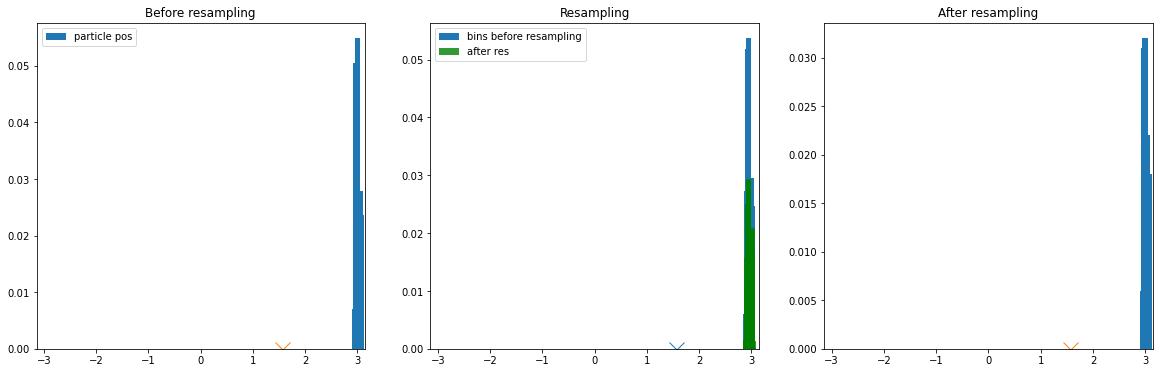

i= 31


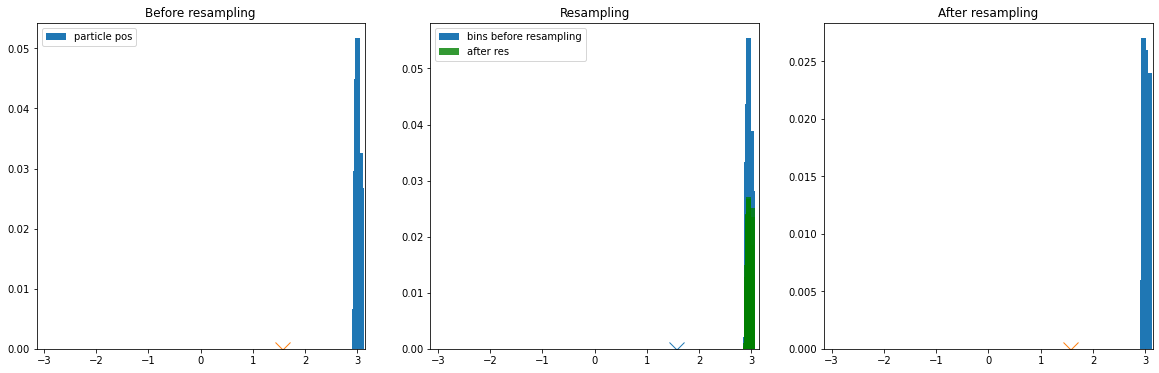

i= 32


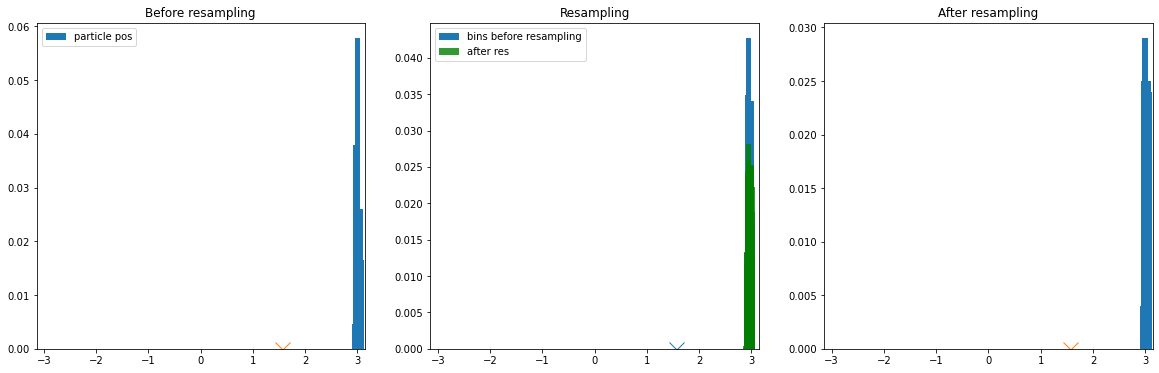

i= 33


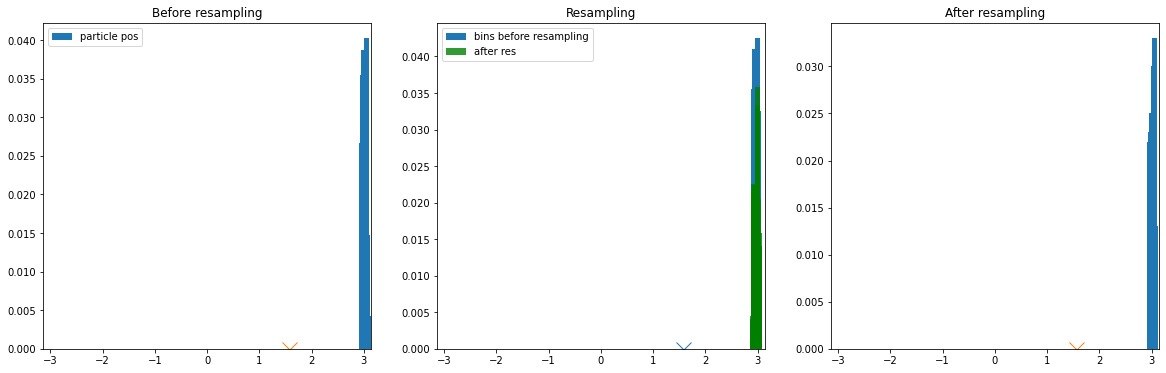

i= 34


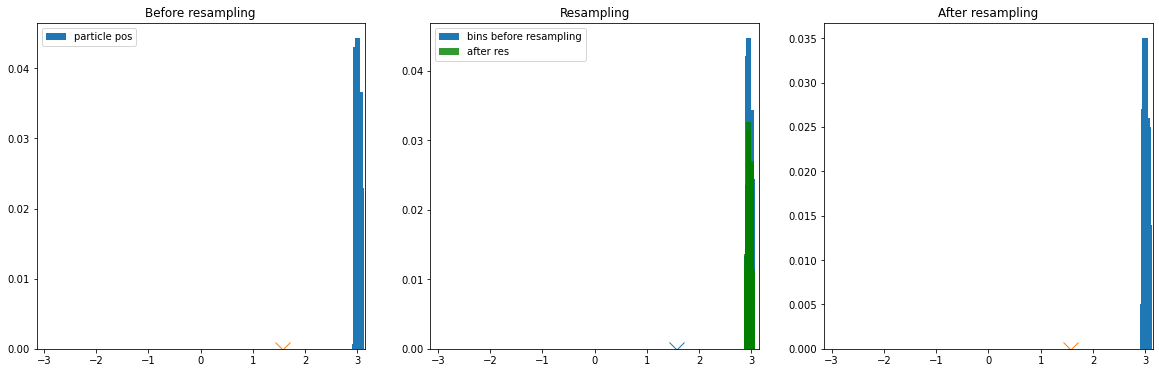

i= 35


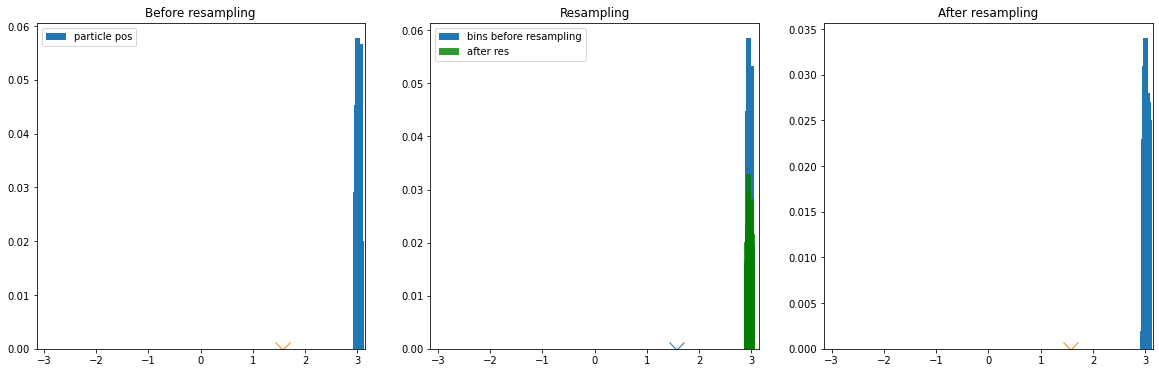

i= 36


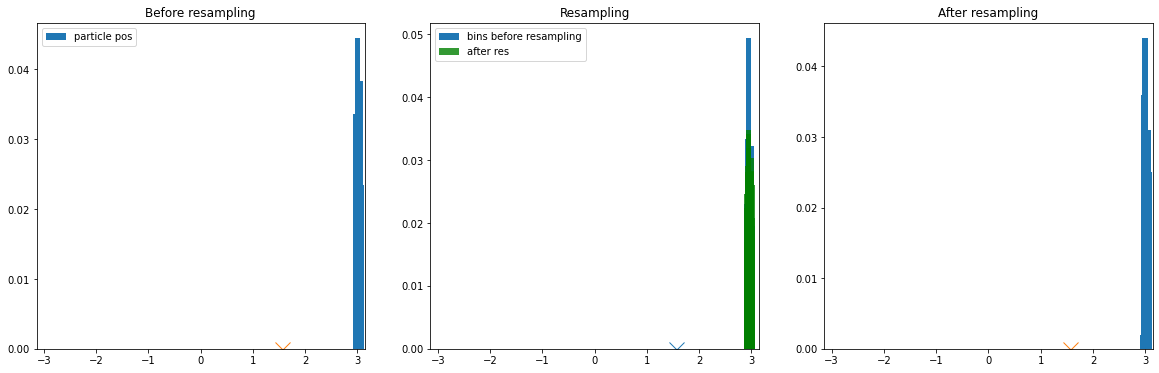

i= 37


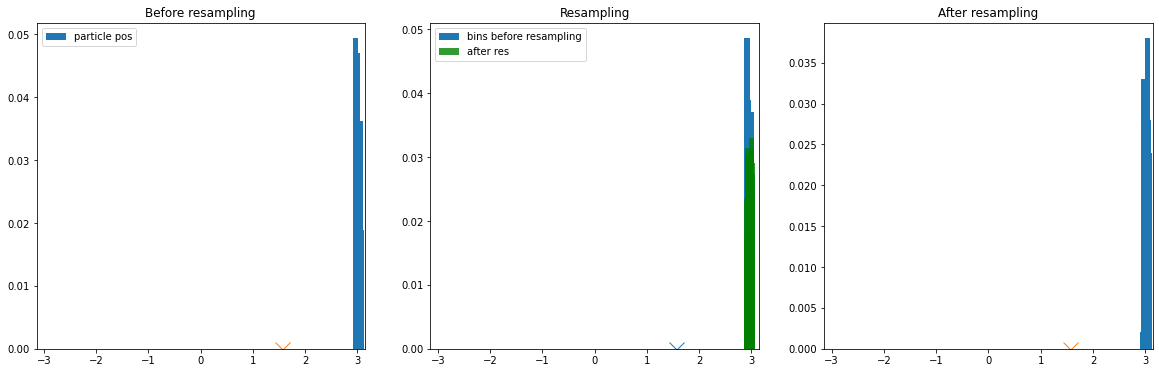

i= 38


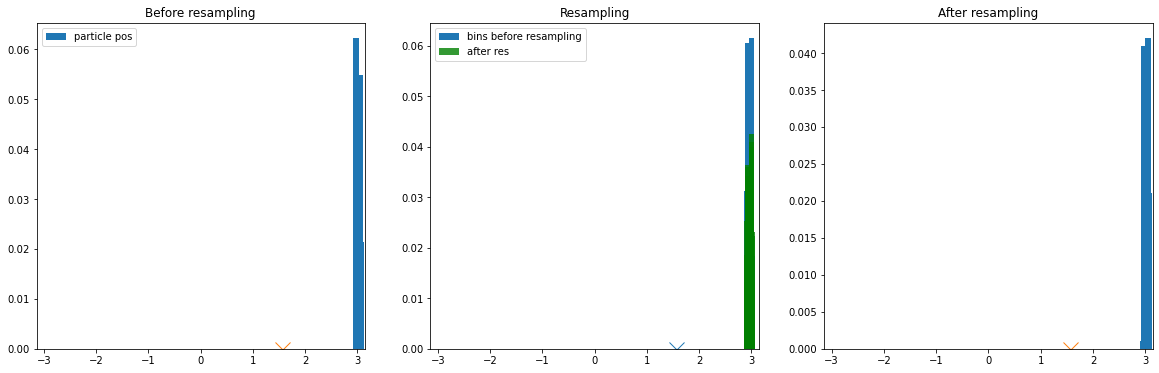

i= 39


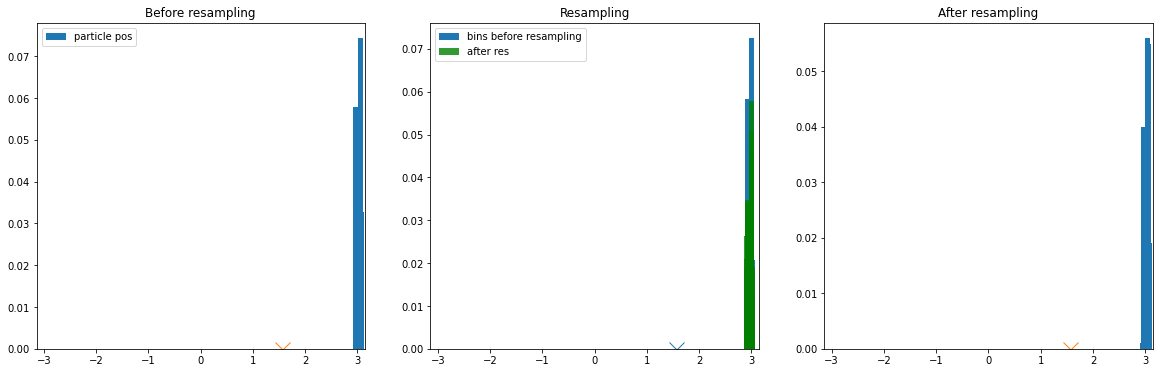

i= 40


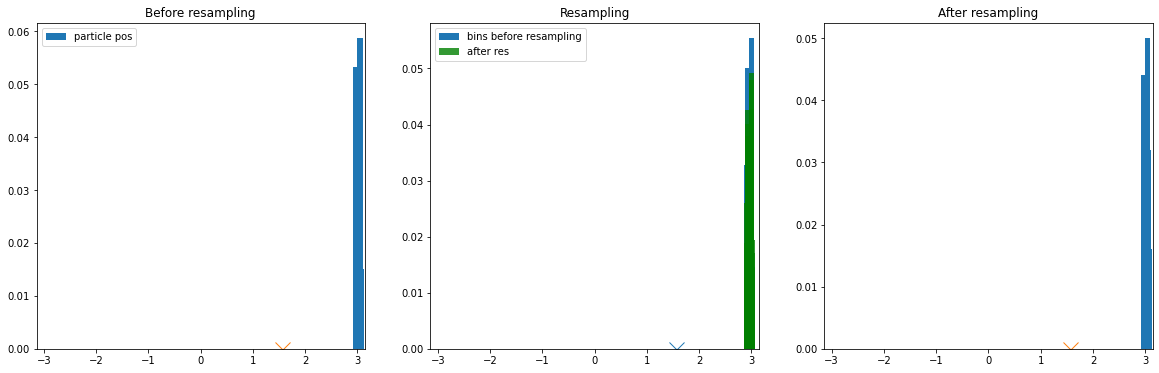

i= 41


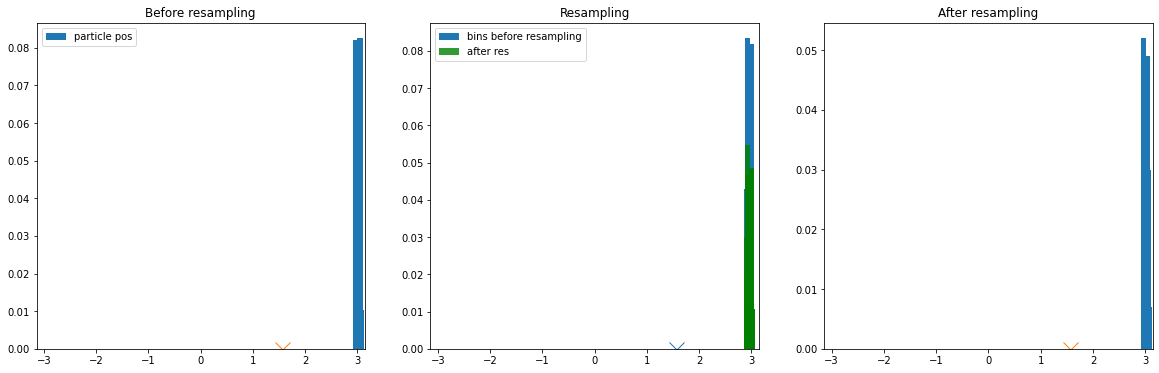

i= 42


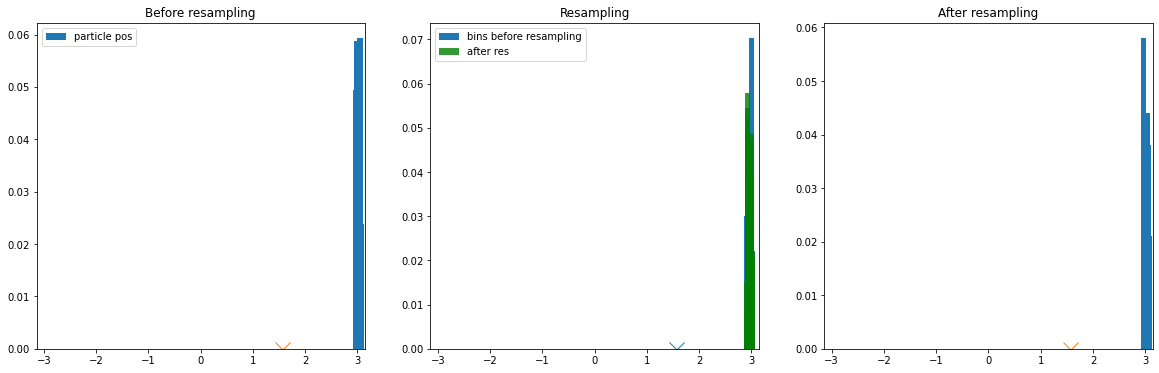

i= 43


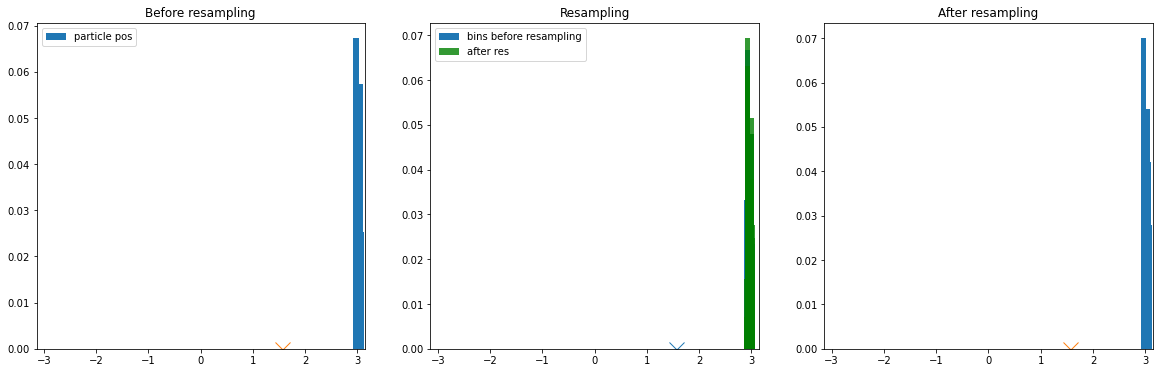

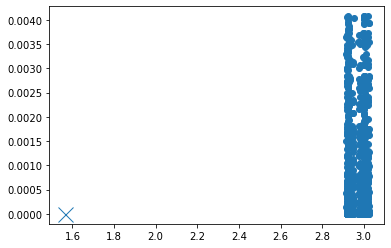

In [58]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    bins_bef_res = smc.memory.bins_edges_bef_res[i][0]
    edges_bef_res = smc.memory.bins_edges_bef_res[i][1]
    bins_aft_res = smc.memory.bins_edges_aft_res[i][0]
    edges_aft_res = edges_bef_res
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]
    edge_width = edges_bef_res[1] - edges_bef_res[0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
                                                  
    print("i=", i)
    
    ax1.hist(pos_bef_res, bins = num_bins, weights = wgt_bef_res, label='particle pos', width=0.1)
    #ax1.bar(edges_bef_res, bins_bef_res, align='edge', width = edge_width, alpha=0.5,color='green', label='bins before res')
    ax1.set_xlim([-np.pi, np.pi])
    ax1.plot(omega_star, 0,marker='x', markersize=15)
    ax1.set_title("Before resampling")
    ax1.legend()
    
    ax2.bar(edges_bef_res, bins_bef_res, align='center', width = 0.1, label='bins before resampling')
    ax2.bar(edges_aft_res, bins_aft_res, align='center', width = 0.1, label='after res' ,alpha=0.8, color='green')
    ax2.set_xlim([-np.pi, np.pi])
    ax2.plot(omega_star, 0,marker='x', markersize=15)
    ax2.set_title("Resampling")
    ax2.legend()
    
    ax3.hist(pos_aft_res, bins = num_bins, weights = wgt_aft_res, width=0.1)
    ax3.plot(omega_star, 0,marker='x', markersize=15)
    ax3.set_xlim([-np.pi, np.pi])
    ax3.set_title("After resampling")
    
    plt.show()

plt.scatter(smc.particle_pos, smc.particle_wgts)
ax = plt.gca()
ax.plot(omega_star, 0,marker='x', markersize=15)
plt.show()
    

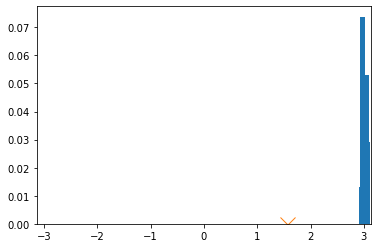

In [59]:
plt.hist(smc.particle_pos, bins=num_bins, weights=smc.particle_wgts, width=0.1)
plt.xlim([-np.pi, np.pi])
plt.plot(omega_star, 0,marker='x', markersize=15)
plt.show()

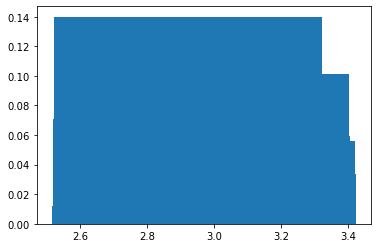

2.922969520525201

In [60]:
bins,edges = np.histogram(smc.particle_pos, bins=50, weights=smc.particle_wgts)
edges = (edges[1:]+edges[:-1])/2

plt.bar(edges,bins)
plt.show()

edges[np.argmax(bins)]


## Liu-West resampler

In [23]:
omega_star_list = []
lw_pred_list = []
lw_data = []

for i in range(n_iters): 
    omega_star = np.random.uniform(low=-1, high=1) * np.pi
    
    omega_star_list.append(omega_star)
    smc = phase_est_smc(omega_star, t0, max_iters)
    smc.init_particles(num_particles)
    
    resample_counts = 0
    
    while True:

        particle_pos, particle_wgts = smc.particles(threshold=num_particles/10, num_measurements=1)
        smc.liu_west_resample()
    
        resample_counts += 1 
        
        curr_omega_est = smc.particle_pos[np.argmax(smc.particle_wgts)]
        if smc.break_flag == True:
            break
        
#         if len(running_est) > 5:
#             last_5 = running_est[-5:]
#             # np.allclose(a,b) returns true if every element in a and b are equal to a tolerance
#             # np.full_like makes an array with shape of last_10 with every element being last_10[0]
#             # if all elements of last_10 are equal then they should all equal the first element
#             if np.allclose(last_5, np.full_like(last_5, last_5[0])):
#                 break
                
      
    if if_print:            
        print("True omega: {:f}, prediction by NN: {:f}, num of resample calls: {:d}".format(omega_star,
                                                                                             smc.curr_omega_est,
                                                                                             resample_counts))

    while len(smc.data) < max_iters:
        smc.data.append(smc.data[-1]) # append the last estimate

    lw_data.append(smc.data)
    lw_pred_list.append(smc.curr_omega_est)
    
    if np.abs(smc.curr_omega_est) - np.abs(omega_star) > 1:
        print("Prediction: {:f}, actual value: {:f}. Threshold exceeded. Breaking out of loop for inspection.".
             format(smc.curr_omega_est, omega_star))
        break
    

True omega: -2.424665, prediction by NN: 0.115004, num of resample calls: 16
True omega: -3.018288, prediction by NN: -4.050359, num of resample calls: 17
Prediction: -4.050359, actual value: -3.018288. Threshold exceeded. Breaking out of loop for inspection.


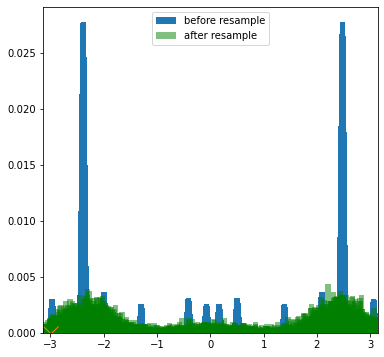

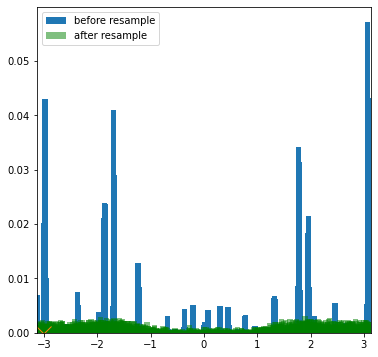

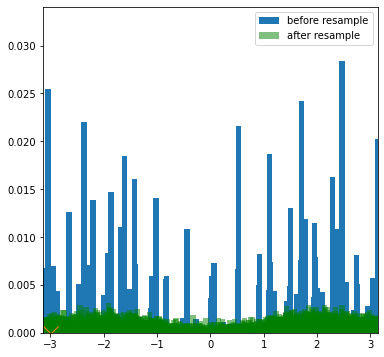

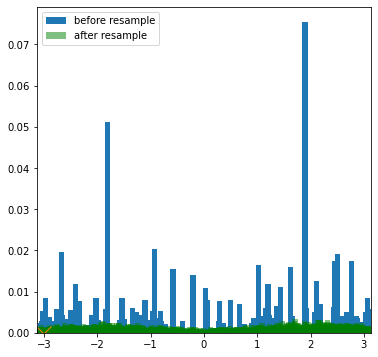

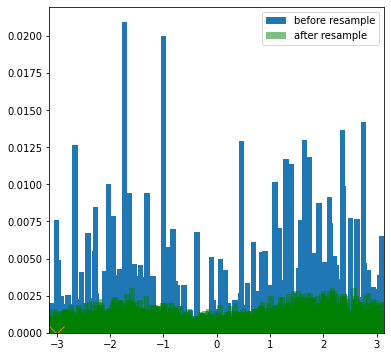

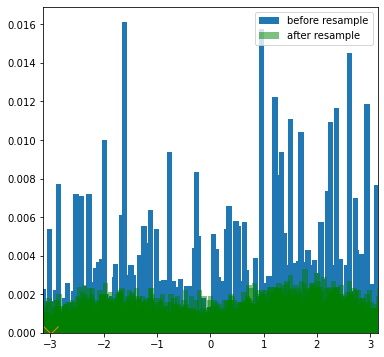

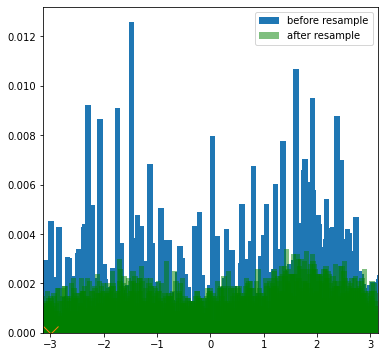

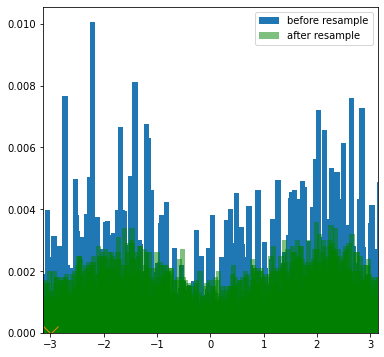

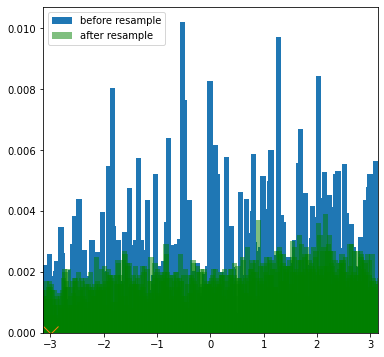

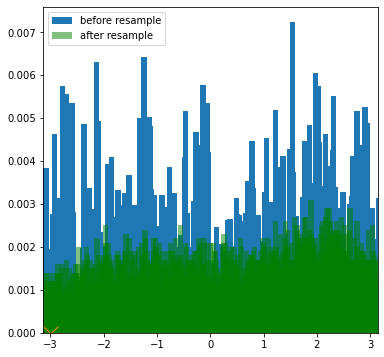

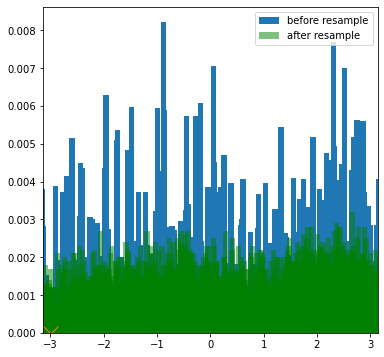

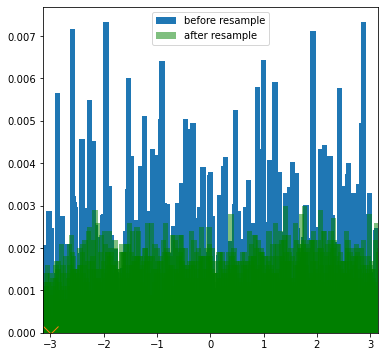

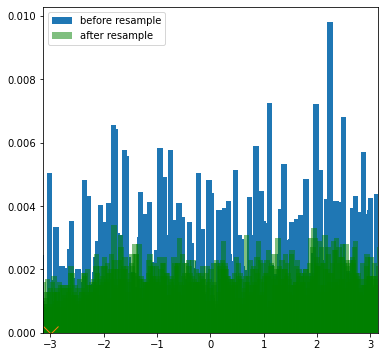

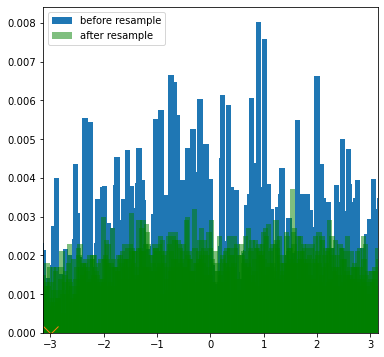

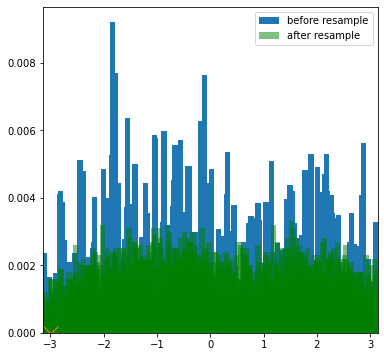

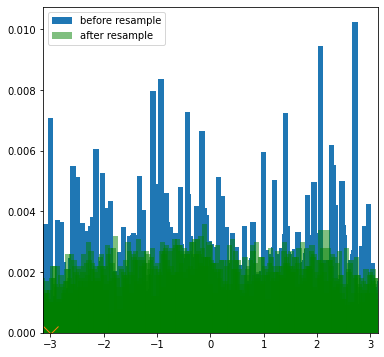

In [24]:
for i in range(len(smc.memory.pos_wgt_bef_res)-1):
    pos_bef_res = smc.memory.pos_wgt_bef_res[i][0]
    wgt_bef_res = smc.memory.pos_wgt_bef_res[i][1]
    pos_aft_res = smc.memory.pos_wgt_aft_res[i][0]
    wgt_aft_res = smc.memory.pos_wgt_aft_res[i][1]

    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    
    ax.hist(pos_bef_res, bins = num_bins, weights = wgt_bef_res, label='before resample', width = 0.1)
    ax.hist(pos_aft_res, bins = num_bins, weights = wgt_aft_res, alpha=0.5, color='green', label='after resample', width=0.1)
    ax.set_xlim([-np.pi, np.pi])
    ax.plot(omega_star, 0,marker='x', markersize=15)
    ax.legend()
    plt.show()
    
    